### Deep Learning Supervised Text Classification
- BiLSTM (transformer-based data augmentation)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [1]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [5]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime

### Load Data

In [7]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance_144_out_df_temp',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210031122', # site compliance or practice issue
    '2210031122', # ppe non-compliance
    '2210032046' # Mechanical or equipment issue
]

fn_aug_names = [
    'hydraulic fluid or oil leak_7920_trda',
    'line strike_8064_trda',
    'site compliance or practice issue_8410_trda',
    'ppe non-compliance_',
    'mechanical or equipment issue_'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: line strike


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [8]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [9]:
base_train_count = len(X_train)
base_train_count

75085

In [10]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 62 [819, 1559, 1779, 2042, 2243, 2546, 2557, 3180, 3471, 3497, 3609, 3661, 4435, 5068, 5999, 6704, 7729, 7905, 8081, 8504, 8792, 9378, 9415, 9703, 9870, 9893, 9935, 10113, 10698, 12444, 12798, 13145, 14488, 14509, 17206, 17367, 17477, 17630, 18430, 18441, 18881, 18902, 18911, 19339, 20728, 21007, 21357, 22261, 22401, 22636, 22831, 22913, 26529, 30086, 40394, 43621, 67311, 78441, 78526, 80754, 86830, 93268]
Train: 264 [285, 289, 333, 511, 791, 824, 871, 999, 1252, 1334, 1361, 1582, 1610, 1621, 1675, 1677, 1681, 1746, 1755, 1786, 1798, 1804, 1952, 1971, 1984, 2025, 2033, 2067, 2070, 2168, 2210, 2276, 2303, 2337, 2377, 2457, 2492, 2614, 2617, 2674, 3016, 3046, 3114, 3355, 3357, 3381, 3434, 3469, 3579, 3644, 3688, 3701, 3706, 3777, 3974, 3997, 4061, 4141, 4535, 4636, 4757, 4910, 5158, 5359, 5470, 5510, 5541, 5576, 5610, 5631, 5670, 5820, 5974, 6114, 6243, 6501, 7736, 7850, 8019, 8031, 8033, 8079, 8102, 8185, 8255, 8359, 8425, 8556, 8746, 8912, 8918, 8922, 8986, 9104, 9110, 9151, 9206

In [11]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues.to_csv('01_data/prepared/df_train_trues.csv')
df_train_trues

,text,category
285,dc cable struck allied fencing employees repor...,1
289,water line strike during drilling operations d...,1
333,mini excavator damaged underground three pvc d...,1
511,soil boring activity aggrevates poor condition...,1
791,it was notice that part of the bank had collap...,1
...,...,...
85446,struck against stationary object or equipment ...,1
86522,other fall to lower level more than thirty fee...,1
89205,direct exposure to electricity greater than tw...,1
91291,indirect exposure to electricity unspecified a...,1


### Transformer Data Augmentation (TrDA)

In [12]:
# Load fabricated reports
fn_name = fn_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_name}.csv')
df_fab

,text,group
0,digger burst buried pipe damaging it no injuri...,line strike
1,digger burst buried pipe resulting in a small ...,line strike
2,digger burst buried pipe connecting pipe on ea...,line strike
3,digger burst buried pipe rack in field inciden...,line strike
4,digger burst buried pipe with teeth at 110mm t...,line strike
...,...,...
8059,minidigger when excavating struck underground ...,line strike
8060,minidigger when excavating struck underground ...,line strike
8061,minidigger when excavating struck underground ...,line strike
8062,minidigger when excavating struck underground ...,line strike


In [13]:
# Prepare data by augmenting the raw (real) training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

df_tmp = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_tmp['category'] = y_train_list
df_tmp

,text,category
0,ip operated air assisted door with left hand w...,0
1,twenty x spiders fell from roof when generator...,0
2,struck by discharged object or substance an em...,0
3,caught in running equipment or machinery n e c...,0
4,caught in running equipment or machinery durin...,0
...,...,...
83144,minidigger when excavating struck underground ...,1
83145,minidigger when excavating struck underground ...,1
83146,minidigger when excavating struck underground ...,1
83147,minidigger when excavating struck underground ...,1


In [14]:
# Shuffle the dataframe
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
df_tmp

,text,category
0,team member received positive test result for ...,0
1,multiple types of overexertion involving outsi...,0
2,irem steel erector was leaving the main pipera...,0
3,jcb came in contact with conduit line in condu...,1
4,whilst hand digging a route for a bt in an exc...,0
...,...,...
83144,theft of generator third incident trespasser e...,0
83145,caught in running equipment or machinery unspe...,0
83146,employees reported gunshots being fired from o...,0
83147,compressed or pinched by shifting objects or e...,0


In [15]:
# Quick visual check of a random sample of 20 (hits)
df_tmp[df_tmp['category']==1].sample(20)

,text,category
77345,digger collided with pipeline causing water ma...,1
10517,digger connected with underground cable operat...,1
33903,operartor hit buried pipe approximately eight ...,1
77612,excavator came in contact with sewer line dama...,1
37612,digger made contact with pvc line below line e...,1
40901,jcb hit sewer line during installation of temp...,1
7784,digger made contact with buried line damaging ...,1
60106,dumper contacted sewer line causing damage to ...,1
20210,jcb connected with buried pipe rack,1
40836,dozer ruptered drain line while excavating a t...,1


## Build Model

In [16]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [17]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [18]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [19]:
X_train = df_tmp.text
y_train = df_tmp.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [20]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 65854
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3292750   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [21]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'contact with hot objects or substances a contracted employee was brought on site to cap off an hdpe methane gas supply line due to leachate coming through the pipe hot leachate one hundred and fifty degrees f released from the pipe and struck an employee who was standing thirty feet away the employee sustained first and second degree burns to the neck chest abdomen and arms that required hospitalization'

### Model Training & Evaluatrion

In [22]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [23]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1]

86830    contact with hot objects or substances a contr...
8792     concrete kibble bucket handle made contact wit...
18441    skid steer with auger bit attachment drilled i...
9415     120v temporary powerline damaged at approximat...
14509    contractor excavator boom struck overhead line...
                               ...                        
5068     hb2216 failure of hydraulic hose supplying the...
30086    direct exposure to electricity greater than tw...
40394    struck by dislodged flying object particle two...
819      plate compactor was damaged when operator turn...
20728    tie accidentally drilled into steam tracing on...
Name: text, Length: 62, dtype: object

In [24]:
# Reminder of test set breakdown
Counter(y_test)

Counter({0: 18710, 1: 62})

In [25]:
# Verify augmented training set breakdown
Counter(y_train)

Counter({0: 74821, 1: 8328})

In [26]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 7495
Number of positives in validation data: 833


In [27]:
# Train the model
print('Training for:', focus_cat)
epoch_num = int(input('Enter epoch number (default is 3): '))
history = model.fit(X_train_vGlove, y_vtrain,
                              validation_data=(X_val_Glove, y_val),
                              epochs=epoch_num,
                              batch_size=128,
                              verbose=1)

Training for: line strike
Enter epoch number (default is 3): 3
Epoch 1/3
585/585 [==============================] - 1827s 3s/step - loss: 0.0928 - categorical_accuracy: 0.9086 - val_loss: 0.0244 - val_categorical_accuracy: 0.8983
Epoch 2/3
585/585 [==============================] - 1798s 3s/step - loss: 0.0311 - categorical_accuracy: 0.8980 - val_loss: 0.0248 - val_categorical_accuracy: 0.9008
Epoch 3/3
585/585 [==============================] - 1791s 3s/step - loss: 0.0254 - categorical_accuracy: 0.9000 - val_loss: 0.0241 - val_categorical_accuracy: 0.8998


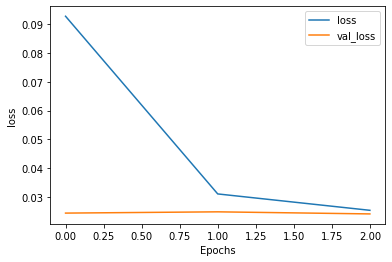

In [28]:
# Plot training history
plot_graphs(history, 'loss')

In [29]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}" with {epoch_num} epochs ... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       0.28      0.35      0.31        62

    accuracy                           0.99     18772
   macro avg       0.64      0.68      0.66     18772
weighted avg       1.00      0.99      1.00     18772





In [30]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  62


In [31]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus_cat}_bda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

NameError: ignored

In [ ]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_trda_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))